# 9 Improving performance

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [2]:
from sklearn.datasets import load_digits

we're going to plot some learning curves for a dataset of digits.
It's not the mnist digits dataset,  we're going to use a smaller size dataset of digits so that our algorithms will perform faster and we are going to be able to repeat many iterations of the training

In [3]:
digits = load_digits()

In [7]:
type(digits)

sklearn.utils.Bunch

In [4]:
X, y = digits.data, digits.target

In [5]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
X.shape

(1797, 64)

In [10]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


it's very similar to the mnist dataset. Only the resolution of this dataset is eight pixel by eight pixels instead of 28 by 28 which will make all of our training algorithms run much faster and we load some very familiar classes from Keras and we are good to go. 

Let's print 8 of them and check.  They are already arranged as you can see in a 64-array vector but if we reshape them to be images of eight by eight 

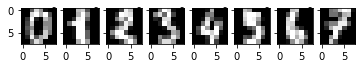

In [15]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

 To clear the session, we build our first model. 
 
 Our first model is going to be a fully connected model with 16 nodes in the first inner layer, 64 input nodes and 10 output nodes with a softmax. 
 
 Also, notice that we want to store the initial weights and we do this because since we are going to run the training multiple times with different train sizes for the learning curve, we want to make sure that the model get reinitialized with the exact same weight each time. 
 
 So, we get the weights from the model and we store them in a variable called initial_weights. 

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping

In [17]:
K.clear_session()

In [18]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

Also, notice that we want to store the initial weights and we do this because since we are going to run the training multiple times with different train sizes for the learning curve, we want to make sure that the model get reinitialized with the exact same weight each time. So, we get the weights from the model and we store them in a variable called initial_weights. We convert our labels to categorical 

In [19]:
# store the initial random weights
initial_weights = model.get_weights()

#later we will use  model.set_weights(initial_weights) to keep the weights consistant

We convert our labels to categorical

In [25]:
y_cat = to_categorical(y, 10)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [23]:
X_train.shape

(1257, 64)

Then we create an array of train sizes and the way we do it is by multiplying the length of X_train, 
#### the training dataset by the linear space of 4 regularly spaced points between 10% and 99.9% of the total number of points. 
Then we convert it to an integer and we have our four train sizes. 

So, just for comparison, the X_train shape is 1,257, 
#### so we're going to train with 125 points, 502 points, 879 points, and then 1,255. 

In [29]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

 The next step is all enclosed in this loop 
 
 For train_size in train_sizes, remember that train_sizes are these four. 
 
 We perform a second train_test_split of the training set with the train_size equal to the train_size we've chosen and we call the split_fraction that we're going to use X_train_fraction. We don't need the test, so we discard it and then y_train_fraction and we don't need the y_test.
 
 But just to be clear, we perform the first train_test_split and we set aside a part of our data and now in the loop, we're going to perform other train_test_splits with increasing fractions of the training set. So, we perform the train_test_split, 
 
 we set the weights, we fit our model with the EarlyStopping callback and 300 epochs maximum, then we evaluate the model on the training_fraction and we append the scores to our empty list of train_scores. Then we also evaluate the model on X_test and y_test and we append the scores to the test_scores list. 

In [32]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


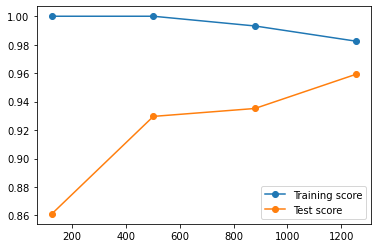

In [33]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

This is our test score as a function of the amount of data we're using for training and this is our training score, so as you can see, the training score is already perfect, it's 100% but the test score goes up significantly as we cross from the first small training_size to the larger 500 point size. 

So, there's probably still room for improvement, so if I had to make a choice between improving the model and getting more data, I would opt for getting more data in this case because the curve seems to be wanting to go even higher. 

So, this is how we use a learning curve. It's a very useful tool, so make sure you use it. 

Sklearn also provides a learning curve function that you may want to experiment with. It does not play very well with Keras and that's why we didn't use it this time but check it out and tell us what you found

## Batch Normalization

In [34]:
from keras.layers import BatchNormalization

 Then what we're going to do is define a function and this function repeats the training. 
 
 So let's see. It takes as argument the x_train, y_train, x_test, y_test, the number of units we want to have in our layers, the type of activation, the optimizer we want and the question do batch normalization(do_bn). It's a boolean yes no. The number of epochs and the repeats.
 
 And then what it does is it repeats the creation and training of a model for the number of repeats. We're gonna do this because this is kind of a in-house cross validation. 

In [39]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [40]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [41]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [42]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

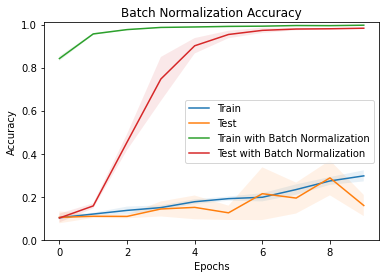

In [43]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')


In this graph, we can see that the probabilities between 0.4 and 0.7 the behavior is pretty stable. We test errors smaller than when all the nodes are retained. In other words, dropping 30 to 60% of the nodes in layer should improve the performance of that layer in a large network.

## Weight Regularization & Dropout

In [48]:
from keras.layers import Dropout

So, in this case, for example, I built a little model with a dropout layer at the very beginning, so that means we drop 20% of the input. So you see it has an input shape that it's equal shape to the 20 shape. And then I've added a second dropout layer, right after the first fully connected. So there's a fully connected layer with 512 nodes, and then a dropout with 40% drop. 

#### So notice that the rate in the dropout layer is defined as the fraction of the input units to drop. So this is very important.

##### The other thing we wanted to highlight is how to introduce regularization in a layer. 
And it's literally just another parameter in the dense layer API. So, as you can see, you can regularize the weight, this is the kernel regularizer. You can regularize the biases. You can even regularize the activity. And the available parameters are L1 and L2, so you can choose between the L2 norm and the L1 norm.

In [56]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 38,410
Trainable params: 38,410
Non-trainable params: 0
_________________________________________________________________


In [58]:
# store the initial random weights
initial_weights = model.get_weights()

#later we will use  model.set_weights(initial_weights) to keep the weights consistant

In [59]:
train_sizes

array([ 125,  502,  879, 1255])

In [60]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


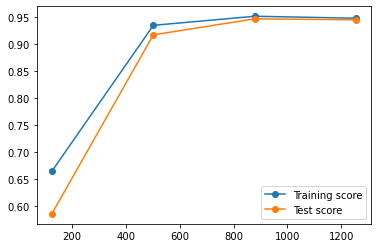

In [61]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

We can see from the above.. the Test Score is significantly improved and stablized at train size 500.

## Data augmentation

from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

#### Data Augmentation
We will present a technique called data augmentation which is useful to generate more data when we cannot collect more data. 
If we shift the image by one pixel, the cat is still there. So our algorithms should still be able to find it. With a simple move, we had just multiplied the amount of data by four: one pixel to the right, one pixel to the left, one up, and one down. If we allow for more than one-pixel moves and for diagonal moves, we can quickly obtain 10 or more times the original dataset. 
This is a good start but there are other more interesting transformations that we can apply. 

For example, we can flip the image left to right. As long as we're not trying to re-text in the image, you should provide perfectly valid training data. We can also rotate the image by a tiny amount or change the aspect ratio by a small bit. We can zoom out or zoom in. 

Notice how all these transformations will contribute to force the network to see a cat regardless of how big or how small or its orientation. We can shear the image, we can turn it into a black-and-white image, it's still a cat, and we can modify the colors a little bit by retaining the shape of a cat. Finally, we can add some random noise or we can even add small occlusions and deletions. As long as a cat is still visible, this should be recognizable by the network. Basically, we should apply any transformation to the image that would still produce an image of a cat and if a human still sees a cat, a machine should be able to see a cat too.

Continuous training is a process from which we flow data continuously and we modify it and our training set becomes a generator that feeds data continuously to the model. So in Keras we can do that with images thanks to the class image data generator. So this is a class that is available in Keras pre-processing image and it does exactly what the name says, it's an image data generator. So remember all those transformations we talked about, changing the scale, shifting the image, rotating the image and so on. These are all available in the image data generator and so we can use just this and have our images changed and converted. Let's have a look at the available parameters. We can rescale the data and here we are rescaling by one over 255 so that our pixels will be between zero and one. Then we can shift the width and the height so this gives us up, down, left, right. 
 

We can rotate by a certain angle. This angle is in degrees and we can also shear the image by a small amount. Finally, we have a zoom range and we allow for horizontal flipping, random flipping of the image. There are also other parameters available that I encourage you to have a look at. The documentation as you know it's our type so have a look at these parameters and see what you can do with the image data generator. 

The generator is only half of the work. Once we've initialized our generator the generator exposes a few interesting methods. So let's have a look at them. We have the metal flow which will take a data set of x and y and flow from the data set that must be in memory by modifying the data set. The more interesting command is flow from directory because in this case we can just pass the directory with a bunch of images and the generator will take care of loading the images in memory modifying them on the fly and passing them to our model. So we don't need to create the data set and store it or load it. 


In [80]:
train = generator.flow_from_directory('../data/generator',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 1 classes.


In [76]:
type(train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

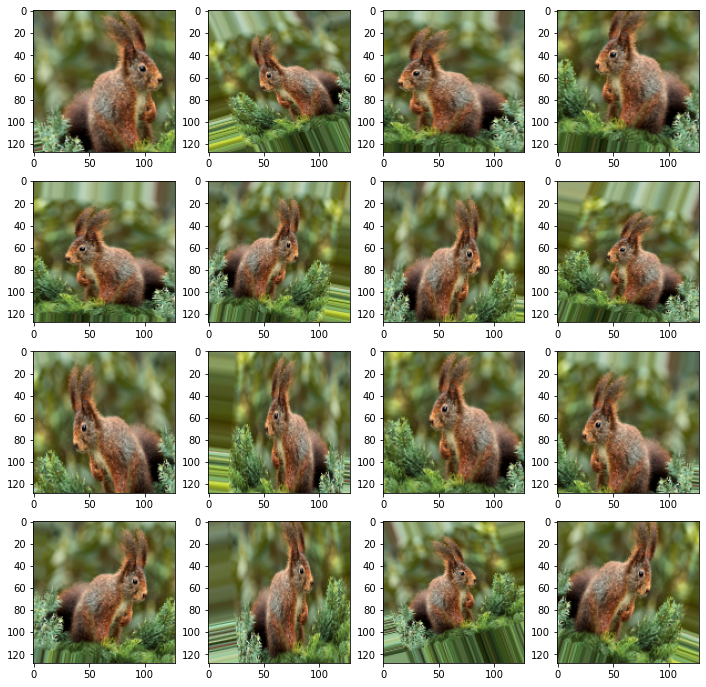

In [77]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

As we've seen, embedding layers are useful when you're dealing with text, because they allow you to go from a very large space to a very reasonable space. 

So the first thing you've got to do is import the embedding layer from the keras layer. Then we're going to build, like we did for the convolutional layers to test them out we're going to build a very simple model with just an embedding layer. We'll have an input dimension of 100 and an output dimension of 2. 

So you see our model only has one embedding layer and it has 200 parameters, because essentially it's a fully connected layer from an input space of 100 nodes to an output space of 2 nodes. 

So the difference between an embedding layer and a fully connected, is that the embedding layer does not need a sparse vector with 100 coordinates but will embed a number between 0 and 99. 

In [82]:
from keras.layers import Embedding

In [83]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


So if it has 100 input space, it's able to interpret each number between 0 and 99. So here we pass a two dimensional array with 12 numbers between 0 and 99, and what the model will do, what the embedding layer will do, is it will convert each of these numbers into two dimensional array, into a two dimensional vector. So let's see the embedded space shape. So as you can see it still has three rows, four columns, but now each of the numbers went from being a number between 0 and 99, to being a vector with two coordinates. Let's have a look at it, yes, so as you can see, each inner element now has 2 coordinates, instead of being a number

In [85]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [86]:
emb.shape

(3, 4, 2)

#Now you can see "81" becomes the two coordinates [[ 0.03535071, -0.02387322]]

In [88]:
emb

array([[[ 0.03535071, -0.02387322],
        [ 0.01205697,  0.02959975],
        [ 0.03311985,  0.02785246],
        [ 0.0323799 , -0.00232358]],

       [[-0.04184161,  0.02789781],
        [ 0.01427931, -0.04600843],
        [-0.04829332, -0.02198622],
        [-0.01348345, -0.01728208]],

       [[-0.01256943,  0.01213443],
        [ 0.0357171 , -0.00374632],
        [-0.02321642, -0.02455133],
        [ 0.03192654,  0.04843507]]], dtype=float32)

## Sentiment prediction on movie Reviews

we will apply what we've learned about embedding layers to a real world problem. Specifically, we want to be able to predict the sentiment of movie reviews. There is a very famous data set of movie reviews, is the IMDB dataset, 

We will download it, and, and we will train a classifier that takes a review as input and predicts whether the review was a positive review or a negative review

In [90]:
from keras.datasets import imdb

The first thing we're gonna look at is the function that we use to load the data. This is imdb.load_data, it stores it in a temporary location, and we are also passing a bunch of parameters, in particular the one parameter,
#### the two parameters you want to pay attention to are the num_words which we've set to None, which means load all the words in the reviews, and the maximum length, which we also set to None. 

Right now, we've loaded all the possible reviews, but you can also trim the data to only passing a certain amount of most common words for example 10,000 or 20,000 most common words in the reviews, and also you can pass a maximum length for the reviews.

In [91]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17465344/17464789 [==============================] - 2s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\dbwab\.conda\envs\python38\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\dbwab\.conda\envs\python38\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

#### There are 25,000 reviews from the Train Set

In [98]:
X_train.shape

(25000,)

If we look at one, it has, it is a long list of numbers. The reason it's a list of numbers is that they've already been converted with a dictionary into an encoding, so the list is the review. 

##### character number one 1 is the starting character, so that's, each list is always going to start with the character number one, with the word number one. 

And then we have two other special character 

###### character number two 2 is used for words that are out of the dictionary, 
###### character number three 3 is the starting index which means the dictionary provided from the IMDB website will need to be shifted by three. 

In [99]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [94]:
idx = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


The index, we can also get from the get_word_index, and it's a dictionary where to each word corresponds a number. As you can see, numbers go as high as 60,000 or more so we can take the values of the index and then take the max to know how many.

##### So there was 88,584 words in the index


In [102]:
max(idx.values())

88584

In [103]:
idx

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

Let's create the reverse index where we swap the keys and the values in the index items, 
#### so for key and value in the index, we create a new dictionary where the key is the number
###### and we also add three so that we actually are able to retrieve the correct words,  and the key becomes the value, 

so what do I mean by this? I mean that reverse index is the reverse of the previous index. The number and the word. And again, if you check, again before, 
##### fawn corresponded to 34,701, and now the same word is the value for 34,704. 

In [104]:
rev_idx = {v+3:k for k,v in idx.items()}

In [105]:
rev_idx

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

We also add to our reverse index, the zero, which is the padding character, the one, which is the start character, and then the two and the three which are the special characters. 



In [106]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [107]:
rev_idx[3]

'unk_char'

In [108]:
y_train[0]

1

Once we've done this, we can convert a review as it's given, for example in X_train zero, for each word in X_train zero, the first review, we take the reverse index of the word and then we join all these words by spaces. So we can get a review. 

In [109]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [110]:
len(X_train[0])

218

In [111]:
len(X_train[1])

189

In [112]:
len(X_train[2])

141

In [113]:
len(X_train[3])

550

o it's very clear that our reviews have different lengths, and we will need to pad these to equal length. Luckily, Keras gives us a pre-processing function to pad our sequences with zeros. We're going to 

##### set a maximum length of 100, 100 words,

and then we're going to pad both the sequences in X_train and in X_test with maximum length of length. 

In [114]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM

In [115]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [116]:
X_train_pad.shape

(25000, 100)

In [117]:
X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,
          32])

In [119]:
example_review_pad = ' '.join([rev_idx[word] for word in X_train_pad[0]])
example_review_pad

"cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

What pad_sequences did was to truncate reviews longer than 100 numbers by cutting away the beginning of the review. 

#### This is called pre-padding or pre-truncation 

if the review was shorter than 100 numbers, we would have added zeros at the beginning. 

In [125]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

We take the maximum of x for both the padding, the X_train padding and the X_test padding, we add one, that's the maximum number of features we have available in the dictionary.

The next step is to build the model and we've loaded a bunch of reviews from the IMDB dataset and our goal is to measure the sentiment of such reviews. 

In [121]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [122]:
y_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [124]:
len(y_train)

25000

In [126]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

The next step is to build the model and we've loaded a bunch of reviews from the IMDB dataset and our goal is to measure the sentiment of such reviews. We will embed our 88,000 words into a 128 vectors feature space and 

then we will pass these vectors to an LSTM. So the LSTM will take the sequence of words and encode it with little dropout and little recurrent dropout 

to return a binary label with a sigmoid, which will tell us if the sentiment is positive or negative.

 In fact, we should've looked at this before, but y_train is a long sequence of ones and zeros, where one is positive sentiment and zero is negative sentiment. We build our model, we compile it, and then we train it. 

In [127]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 110s 202ms/step - loss: 0.4297 - accuracy: 0.7991 - val_loss: 0.3761 - val_accuracy: 0.8424
Epoch 2/2
547/547 [==============================] - 108s 197ms/step - loss: 0.1959 - accuracy: 0.9258 - val_loss: 0.3849 - val_accuracy: 0.8475


In [128]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 8s 10ms/step - loss: 0.4033 - accuracy: 0.8382
Test score: 0.4032517075538635
Test accuracy: 0.83815997838974


Our test score on the test set is 83.6% which is actually not bad on these dataset in just two epochs. I